In [1]:
# ==============================================================================
# SEL 1: Inisialisasi Library dan Penyiapan Seed
# ==============================================================================

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
import random
import os

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K


# Menetapkan seed untuk reproduktifitas hasil
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = '42'
# Untuk memastikan hasil tetap sama saat dijalankan ulang
tf.config.experimental.enable_op_determinism()


In [2]:
# ==============================================================================
# SEL 2: Memuat Data Saham
# ==============================================================================

# Nama file CSV data saham
stock_file_name = "ANTM.csv"
# Membaca CSV
df = pd.read_csv("ANTM.csv")  # Menyesuaikan delimiter

# Menampilkan hasil
print(df)  # Cek apakah kolom sudah benar

# Konversi kolom 'Date' menjadi format datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)


            Date  Close
0       2/1/2020    840
1       3/1/2020    850
2       6/1/2020    885
3       7/1/2020    875
4       8/1/2020    905
...          ...    ...
1167  25/10/2024   1585
1168  28/10/2024   1610
1169  29/10/2024   1615
1170  30/10/2024   1630
1171  31/10/2024   1600

[1172 rows x 2 columns]


In [3]:
# ==============================================================================
# SEL 3: Memeriksa Nilai Null
# ==============================================================================

# Memeriksa data untuk nilai null
print("\nCek Nilai Null:")
print(df.isnull().sum())

if df.isnull().sum().any():
    print("\nWarning: Terdapat nilai null.")
else:
    print("\nTidak ada nilai null ditemukan.")


Cek Nilai Null:
Close    0
dtype: int64

Tidak ada nilai null ditemukan.


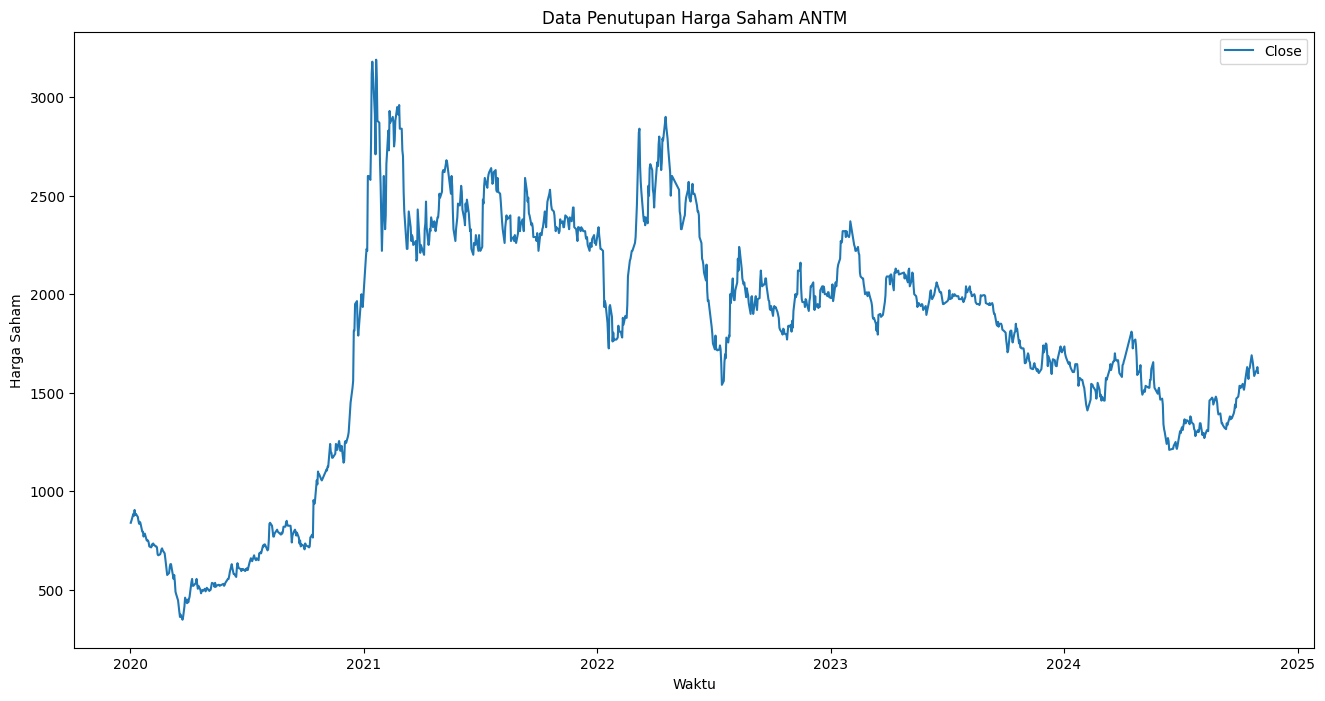


Grafik historis harga saham ANTM telah ditampilkan.


In [4]:
# ==============================================================================
# SEL 4: Visualisasi Data Historis
# ==============================================================================

# Ekstrak nama saham dari nama file untuk judul grafik
stock_name = stock_file_name.replace(".csv", "").upper()
# Visualisasi data historis
plt.figure(figsize=(16, 8))
plt.plot(df['Close'], label='Close')
plt.title(f'Data Penutupan Harga Saham {stock_name}')
plt.xlabel('Waktu')
plt.ylabel('Harga Saham')
plt.legend()
plt.show()

print(f"\nGrafik historis harga saham {stock_name} telah ditampilkan.")

In [5]:
# ==============================================================================
# SEL 5: Normalisasi Data
# ==============================================================================

# Menormalisasi data dengan MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df[['Close']].values)
print("\nData Normalisasi:")
print(data_scaled)
print(f"Nilai terendah data asli (Xmin): {scaler.data_min_[0]:.2f}")
print(f"Nilai tertinggi data asli (Xmax): {scaler.data_max_[0]:.2f}")


Data Normalisasi:
[[0.17311752]
 [0.17663617]
 [0.18895144]
 ...
 [0.44581281]
 [0.45109078]
 [0.44053483]]
Nilai terendah data asli (Xmin): 348.00
Nilai tertinggi data asli (Xmax): 3190.00


In [6]:
# ==============================================================================
# SEL 6: Pembagian Data Latih dan Uji
# ==============================================================================

# Membagi data menjadi latih dan uji
training_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[:training_size], data_scaled[training_size:]
print("Ukuran data training: ", train_data.shape)
print("Ukuran data testing : ", test_data.shape)

Ukuran data training:  (937, 1)
Ukuran data testing :  (235, 1)


In [7]:
# ==============================================================================
# SEL 7: Pembuatan Dataset Time-Series
# ==============================================================================

# Fungsi untuk membuat dataset time-series
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        dataX.append(dataset[i:(i + time_step), 0]) # Ambil time_step data sebagai input
        dataY.append(dataset[i + time_step, 0]) # Data berikutnya sebagai prediksi
    return np.array(dataX), np.array(dataY)

# Definisikan time step
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)
print("Shape y_train:", y_train.shape)
print("Shape y_test:", y_test.shape)

Shape X_train: (877, 60)
Shape X_test: (175, 60)
Shape y_train: (877,)
Shape y_test: (175,)


In [8]:
# ==============================================================================
# SEL 8: Reshape Input untuk LSTM
# ==============================================================================

# Mengubah bentuk input untuk LSTM: (sampel, time_step, fitur)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)

Shape X_train: (877, 60, 1)
Shape X_test: (175, 60, 1)


In [9]:
# ==============================================================================
# SEL 9: Membangun dan Melatih Model LSTM
# ==============================================================================

# Membuat Model LSTM
n_neurons = 50
epochs = 200
batch_size = 32

model = Sequential([
    LSTM(n_neurons, activation='tanh', recurrent_activation="sigmoid", input_shape=(time_step, 1)),
    Dense(1) # Menggunakan sigmoid untuk output layer
])

# Mengkompilasi model (Optimizer Adam, Loss MSE)
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Melatih model
print(f"\nMemulai pelatihan model LSTM (Epochs={epochs}, Batch Size={batch_size})...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)
print("\nPelatihan selesai.")


Memulai pelatihan model LSTM (Epochs=200, Batch Size=32)...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - loss: 0.1631 - val_loss: 9.2062e-04
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0067 - val_loss: 0.0017
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0036 - val_loss: 0.0013
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0029 - val_loss: 9.9164e-04
Epoch 5/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0025 - val_loss: 8.3497e-04
Epoch 6/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0024 - val_loss: 7.6368e-04
Epoch 7/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0023 - val_loss: 7.3298e-04
Epoch 8/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0022 - val_loss: 7.1485e-04
Epoch 9/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0021 - val_loss: 7.0337e-04
Epoch 10/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0020 - val_loss: 6.9780e-04
Epoch 11/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0020 - val_loss: 6.9596e-04
Epoch 12/200
28/

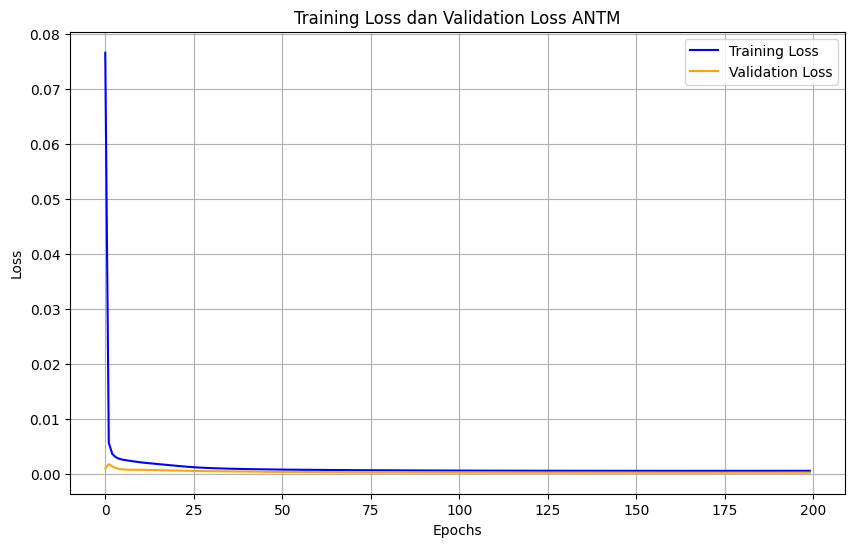


Grafik Training Loss dan Validation Loss telah ditampilkan.


In [10]:
# ==============================================================================
# SEL 10: Visualisasi Training Loss dan Validation Loss
# ==============================================================================

# Visualisasi Training Loss dan Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title(f'Training Loss dan Validation Loss {stock_name}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print("\nGrafik Training Loss dan Validation Loss telah ditampilkan.")

In [11]:
# ==============================================================================
# SEL 11: Ekstraksi Bobot dan Bias Awal LSTM
# Untuk menyimpan bobot awal model yang dilatih Keras
# ==============================================================================

#  Ambil Bobot Awal dari layer LSTM dan Dense
lstm_weights = model.layers[0].get_weights()
W, U, b = lstm_weights[0], lstm_weights[1], lstm_weights[2]

dense_weights = model.layers[1].get_weights()
Wd, bd = dense_weights[0], dense_weights[1]

# Pecah Bobot LSTM ke Setiap Gate (sesuai urutan di skripsi: f, i, c, o)

def split_weights(W, U, b):
    W_i, W_f, W_c, W_o = np.split(W, 4, axis=1)  # kernel weights
    U_i, U_f, U_c, U_o = np.split(U, 4, axis=1)  # recurrent weights
    b_i, b_f, b_c, b_o = np.split(b, 4)  # biases
    return (W_i, U_i, b_i), (W_f, U_f, b_f), (W_c, U_c, b_c), (W_o, U_o, b_o)

(Wi, Ui, bi), (Wf, Uf, bf), (Wc, Uc, bc), (Wo, Uo, bo) = split_weights(W, U, b)

# Keras menyimpan dalam urutan (i, f, c, o)
target_file = "LSTM_Weights.xlsx"
with pd.ExcelWriter(target_file) as writer:
    pd.DataFrame(Wi).to_excel(writer, sheet_name="Wi")
    pd.DataFrame(Ui).to_excel(writer, sheet_name="Ui")
    pd.DataFrame(bi).to_excel(writer, sheet_name="bi")

    pd.DataFrame(Wf).to_excel(writer, sheet_name="Wf")
    pd.DataFrame(Uf).to_excel(writer, sheet_name="Uf")
    pd.DataFrame(bf).to_excel(writer, sheet_name="bf")

    pd.DataFrame(Wc).to_excel(writer, sheet_name="Wc")
    pd.DataFrame(Uc).to_excel(writer, sheet_name="Uc")
    pd.DataFrame(bc).to_excel(writer, sheet_name="bc")

    pd.DataFrame(Wo).to_excel(writer, sheet_name="Wo")
    pd.DataFrame(Uo).to_excel(writer, sheet_name="Uo")
    pd.DataFrame(bo).to_excel(writer, sheet_name="bo")

print(f"\n== File {target_file} telah disimpan! ==")



== File LSTM_Weights.xlsx telah disimpan! ==


In [12]:
# ==============================================================================
# SEL 12: Simulasi Perhitungan Manual Forward Pass Pada Batch Pertama
# ==============================================================================

# Fungsi Sigmoid dan Tanh untuk Perhitungan Manual
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

# Hitung Forward Pass

def lstm_forward(X, Wi, Ui, bi, Wf, Uf, bf, Wo, Uo, bo, Wc, Uc, bc):
    batch_size, time_steps, input_dim = X.shape
    hidden_dim = Ui.shape[0]  # Jumlah unit LSTM

    h_t = np.zeros((batch_size, hidden_dim))  # Hidden state awal
    c_t = np.zeros((batch_size, hidden_dim))  # Cell state awal

    for t in range(time_steps):
        x_t = X[:, t, :]  # Ambil input per time step

        # Hitung setiap gate
        i_t = sigmoid(np.dot(x_t, Wi) + np.dot(h_t, Ui) + bi)  # Input gate
        f_t = sigmoid(np.dot(x_t, Wf) + np.dot(h_t, Uf) + bf)  # Forget gate
        o_t = sigmoid(np.dot(x_t, Wo) + np.dot(h_t, Uo) + bo)  # Output gate
        c_tilde = tanh(np.dot(x_t, Wc) + np.dot(h_t, Uc) + bc)  # Candidate cell state

        # Update cell state dan hidden state
        c_t = f_t * c_t + i_t * c_tilde
        h_t = o_t * tanh(c_t)

    return i_t, f_t, o_t, c_tilde, h_t, c_t

# Ambil batch pertama
batch_sample = X_train[:16]

# Hitung forward pass
i_t, f_t, o_t, c_tilde, h_t, c_t = lstm_forward(
    batch_sample, Wi, Ui, bi, Wf, Uf, bf, Wo, Uo, bo, Wc, Uc, bc
)

# Hitung Output dari Dense Layer
dense_weights = model.layers[1].get_weights()
Wd, bd = dense_weights[0], dense_weights[1]
dense_output = np.dot(h_t, Wd) + bd

# Simpan Hasil Forward Pass ke dalam Excel
target_file = "LSTM_Forward_Pass.xlsx"
with pd.ExcelWriter(target_file) as writer:
    pd.DataFrame(i_t).to_excel(writer, sheet_name="Input_Gate")
    pd.DataFrame(f_t).to_excel(writer, sheet_name="Forget_Gate")
    pd.DataFrame(o_t).to_excel(writer, sheet_name="Output_Gate")
    pd.DataFrame(c_tilde).to_excel(writer, sheet_name="Cell_Candidate")
    pd.DataFrame(h_t).to_excel(writer, sheet_name="Hidden_State")
    pd.DataFrame(c_t).to_excel(writer, sheet_name="Cell_State")
    pd.DataFrame(dense_output).to_excel(writer, sheet_name="Dense_Output")

print(f"\n== File {target_file} telah disimpan! ==")



== File LSTM_Forward_Pass.xlsx telah disimpan! ==


In [13]:
# ==============================================================================
# SEL 13: Simulasi Perhitungan Manual Gradien (Backpropagation)
# ==============================================================================

# Cek apakah model sudah dilatih
assert 'model' in globals(), "Model belum dilatih! Jalankan pelatihan terlebih dahulu."

# Definisikan fungsi loss
loss_fn = tf.keras.losses.MeanSquaredError()

# Gunakan GradientTape untuk menghitung gradien
def compute_gradients(model, X_batch, y_batch):
    with tf.GradientTape() as tape:
        predictions = model(X_batch, training=True)
        loss = loss_fn(y_batch, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    return gradients

# Ambil batch pertama untuk perhitungan gradien
X_batch, y_batch = X_train[:16], y_train[:16]
gradients = compute_gradients(model, X_batch, y_batch)

# 4. Pecah gradien ke setiap gate
W_grad, U_grad, b_grad = gradients[0].numpy(), gradients[1].numpy(), gradients[2].numpy()

def split_gradients(W, U, b):
    dWi, dWf, dWc, dWo = np.split(W, 4, axis=1)
    dUi, dUf, dUc, dUo = np.split(U, 4, axis=1)
    dbi, dbf, dbc, dbo = np.split(b, 4)
    return (dWi, dUi, dbi), (dWf, dUf, dbf), (dWc, dUc, dbc), (dWo, dUo, dbo)

(dWi, dUi, dbi), (dWf, dUf, dbf), (dWc, dUc, dbc), (dWo, dUo, dbo) = split_gradients(W_grad, U_grad, b_grad)

# 5. Simpan hasil gradien ke dalam file Excel
file_name = "LSTM_Gradients.xlsx"
with pd.ExcelWriter(file_name) as writer:
    pd.DataFrame(dWi).to_excel(writer, sheet_name="dWi")
    pd.DataFrame(dUi).to_excel(writer, sheet_name="dUi")
    pd.DataFrame(dbi).to_excel(writer, sheet_name="dbi")

    pd.DataFrame(dWf).to_excel(writer, sheet_name="dWf")
    pd.DataFrame(dUf).to_excel(writer, sheet_name="dUf")
    pd.DataFrame(dbf).to_excel(writer, sheet_name="dbf")

    pd.DataFrame(dWc).to_excel(writer, sheet_name="dWc")
    pd.DataFrame(dUc).to_excel(writer, sheet_name="dUc")
    pd.DataFrame(dbc).to_excel(writer, sheet_name="dbc")

    pd.DataFrame(dWo).to_excel(writer, sheet_name="dWo")
    pd.DataFrame(dUo).to_excel(writer, sheet_name="dUo")
    pd.DataFrame(dbo).to_excel(writer, sheet_name="dbo")

print(f"\n== File {file_name} telah disimpan! ==")



== File LSTM_Gradients.xlsx telah disimpan! ==


In [14]:
# ==============================================================================
# SEL 14: Simulasi Perhitungan Manual Update Bobot Adam
# ==============================================================================

# Adam Optimizer Parameters
learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# Inisialisasi m dan v untuk Adam
m_W, v_W = np.zeros_like(W), np.zeros_like(W)
m_U, v_U = np.zeros_like(U), np.zeros_like(U)
m_b, v_b = np.zeros_like(b), np.zeros_like(b)

t = 1  # Iterasi pertama Adam

def adam_update(param, grad, m, v, t, lr=learning_rate, beta1=beta1, beta2=beta2, eps=epsilon):
    """Fungsi untuk memperbarui parameter menggunakan Adam optimizer"""
    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * (grad ** 2)
    m_hat = m / (1 - beta1 ** t)
    v_hat = v / (1 - beta2 ** t)
    param -= lr * m_hat / (np.sqrt(v_hat) + eps)
    return param, m, v

# Update bobot dan bias untuk setiap gate
W_new, m_W, v_W = adam_update(W, W_grad, m_W, v_W, t)
U_new, m_U, v_U = adam_update(U, U_grad, m_U, v_U, t)
b_new, m_b, v_b = adam_update(b, b_grad, m_b, v_b, t)

# Pecah bobot baru ke dalam setiap gate
(Wi_new, Ui_new, bi_new), (Wf_new, Uf_new, bf_new), (Wc_new, Uc_new, bc_new), (Wo_new, Uo_new, bo_new) = split_weights(W_new, U_new, b_new)

# Simpan bobot baru ke dalam file Excel
updated_weights_file = "LSTM_Updated_Weights.xlsx"
with pd.ExcelWriter(updated_weights_file) as writer:
    pd.DataFrame(Wi_new).to_excel(writer, sheet_name="Wi_New")
    pd.DataFrame(Ui_new).to_excel(writer, sheet_name="Ui_New")
    pd.DataFrame(bi_new).to_excel(writer, sheet_name="bi_New")

    pd.DataFrame(Wf_new).to_excel(writer, sheet_name="Wf_New")
    pd.DataFrame(Uf_new).to_excel(writer, sheet_name="Uf_New")
    pd.DataFrame(bf_new).to_excel(writer, sheet_name="bf_New")

    pd.DataFrame(Wc_new).to_excel(writer, sheet_name="Wc_New")
    pd.DataFrame(Uc_new).to_excel(writer, sheet_name="Uc_New")
    pd.DataFrame(bc_new).to_excel(writer, sheet_name="bc_New")

    pd.DataFrame(Wo_new).to_excel(writer, sheet_name="Wo_New")
    pd.DataFrame(Uo_new).to_excel(writer, sheet_name="Uo_New")
    pd.DataFrame(bo_new).to_excel(writer, sheet_name="bo_New")

print(f"\n== Bobot dan bias baru telah disimpan di {updated_weights_file}! ==")



== Bobot dan bias baru telah disimpan di LSTM_Updated_Weights.xlsx! ==


In [15]:
# ==============================================================================
# SEL 15: Evaluasi Model dengan MAPE
# ==============================================================================

# 3. Evaluasi Model
# Membuat prediksi
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Mengembalikan data ke skala aslinya
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Menghitung metrik evaluasi untuk data latih dan uji
train_mape = np.mean(np.abs((y_train_original - train_predict) / y_train_original)) * 100
test_mape = np.mean(np.abs((y_test_original - test_predict) / y_test_original)) * 100

print("\nEvaluasi Model:")
print(f"Train MAPE: {train_mape}%")
print(f"Test MAPE: {test_mape}%")

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Evaluasi Model:
Train MAPE: 2.3013422625554165%
Test MAPE: 1.8630834235319909%


In [16]:
# Mengambil bobot dari layer LSTM
lstm_layer = model.layers[0]  # Lapisan LSTM
weights = lstm_layer.get_weights()


# Memisahkan bobot menjadi Kernel (W), Recurrent weights (U), dan Bias (b)
W = weights[0]  # Kernel weights (input to gates)
U = weights[1]  # Recurrent weights (hidden state to gates)
b = weights[2]  # Bias

# Menampilkan ukuran setiap bobot
print("Shape of W (bobot input):", W.shape)
print("Shape of U (Bobot hidden state):", U.shape)
print("Shape of b (Bias):", b.shape)

# Memisahkan bobot untuk setiap gate
units = lstm_layer.units  # Jumlah unit (neurons) dalam LSTM

W_f, W_i, W_c, W_o = W[:, :units], W[:, units:2*units], W[:, 2*units:3*units], W[:, 3*units:]
U_f, U_i, U_c, U_o = U[:, :units], U[:, units:2*units], U[:, 2*units:3*units], U[:, 3*units:]
b_f, b_i, b_c, b_o = b[:units], b[units:2*units], b[2*units:3*units], b[3*units:]


Shape of W (bobot input): (1, 200)
Shape of U (Bobot hidden state): (50, 200)
Shape of b (Bias): (200,)


In [17]:
# Menampilkan bobot untuk Forget Gate
print("W_f (Bobot Input untuk Forget Gate):\n", W_f)
print("U_f (Bobot hidden state untuk Forget Gate):\n", U_f)
print("b_f (Bias untuk Forget Gate):\n", b_f)

print("Shape of W_f:", W_f.shape)
print("Shape of U_f:", U_f.shape)
print("Shape of b_f:", b_f.shape)

W_f (Bobot Input untuk Forget Gate):
 [[ 0.19651921  0.15816128 -0.04547196  0.13917594 -0.26363873  0.07339842
   0.11060226 -0.16297275  0.04428442  0.20182574 -0.00731117  0.02426272
   0.22152908  0.00269805  0.02233916  0.2603532  -0.19221309 -0.09714632
  -0.00483643  0.71125495 -0.08692916  0.21685053  0.13118927  0.0637133
   0.26601174 -0.096108    0.05032527  0.08629187  0.11811549 -0.08213951
  -0.07218976  0.20833224 -0.1233495   0.05219086 -0.12109581 -0.21438399
   0.14355373  0.04565588  0.10099605  0.06072797 -0.18800959  0.34990707
  -0.03046206  0.04968726  0.2975232   0.06356241  0.03593529 -0.11970481
  -0.06548019  0.16539164]]
U_f (Bobot hidden state untuk Forget Gate):
 [[ 0.03961435  0.00034023  0.04839431 ... -0.03235087 -0.08223119
  -0.02217324]
 [ 0.05556709  0.04866324 -0.00866864 ... -0.16195877  0.00250857
   0.19397582]
 [-0.02981112  0.02456005  0.0159715  ... -0.02793505 -0.05456218
   0.00857959]
 ...
 [ 0.01661493 -0.01149483  0.05465867 ...  0.13730

In [18]:
# Menampilkan bobot untuk Input Gate
print("W_i (Bobot Input untuk Input Gate):\n", W_i)
print("U_i (Bobot hidden state untuk Input Gate):\n", U_i)
print("b_i (Bias untuk Input Gate):\n", b_i)
print("Shape of W_i:", W_i.shape)
print("Shape of U_i:", U_i.shape)
print("Shape of b_i:", b_i.shape)

W_i (Bobot Input untuk Input Gate):
 [[ 0.06800012  0.06683236 -0.16201198 -0.1393788   0.00865403  0.13286279
  -0.05072228 -0.1045672  -0.09697407  0.01457439  0.14101285  0.14289011
   0.00555825  0.09274238 -0.04207651  0.21606347 -0.08074606 -0.03950335
   0.12536342 -0.01751206  0.12488084  0.19208926  0.13111855 -0.01563269
   0.19318447 -0.13090092  0.19997808  0.10633669  0.06037959 -0.10409617
  -0.0870677   0.19106863 -0.1434842   0.0045297  -0.12713023 -0.17445134
   0.16185105  0.2438188   0.06662249  0.01291768 -0.00329212  0.30836374
   0.01069017 -0.08503657  0.22904581  0.02193206  0.11355338  0.10520031
   0.01942995 -0.14205258]]
U_i (Bobot hidden state untuk Input Gate):
 [[ 0.06439713  0.11891523 -0.15642117 ... -0.02020186  0.03871364
  -0.08881866]
 [-0.11144857  0.02088708  0.03617713 ... -0.19055328 -0.01282722
   0.12921508]
 [-0.10905521  0.07605426 -0.00412791 ... -0.03979436 -0.05858523
   0.0592432 ]
 ...
 [ 0.07241239  0.16069438 -0.02750723 ... -0.059872

In [19]:
# Menampilkan bobot untuk Cell State
print("W_c (Bobot Input untuk Cell State):\n", W_c)
print("U_c (Bobot hidden state untuk Cell State):\n", U_c)
print("b_c (Bias untuk Cell State):\n", b_c)
print("Shape of W_c:", W_c.shape)
print("Shape of U_c:", U_c.shape)
print("Shape of b_c:", b_c.shape)

W_c (Bobot Input untuk Cell State):
 [[ 0.22470315  0.19724923  0.03425319 -0.0727237  -0.06723207  0.12646164
  -0.09734805  0.00798517  0.06973542  0.04403018 -0.15816058  0.11492325
  -0.06499886  0.14639267  0.02749194 -0.12713663  0.11418013 -0.15829588
  -0.07688869 -0.83065313  0.04287808 -0.20651986 -0.10458189  0.22875845
   0.06684517 -0.12755424  0.17706501 -0.18936898  0.10299476 -0.14132495
   0.13416597 -0.11016285 -0.01471714 -0.03038564 -0.03432823 -0.10528483
  -0.0451098  -0.0074454   0.19614628 -0.10027567 -0.14785664 -0.22720677
   0.05833498  0.18282244  0.17366286  0.07860719 -0.0323764   0.13810477
  -0.00769852 -0.13118613]]
U_c (Bobot hidden state untuk Cell State):
 [[-0.1601258   0.05025344  0.03763975 ... -0.04446222  0.10754572
   0.01556779]
 [-0.01943657  0.01566005  0.13628176 ...  0.05922569 -0.06924944
  -0.01826777]
 [ 0.03162216  0.10568837 -0.0690406  ...  0.03405293  0.06301318
  -0.00181701]
 ...
 [ 0.14384247 -0.05183891  0.11166451 ...  0.029133

In [20]:
# Menampilkan bobot untuk Output Gate
print("W_o (Bobot Input untuk Output Gate):\n", W_o)
print("U_o (Bobot hidden state untuk Output Gate):\n", U_o)
print("b_o (Bias untuk Output Gate):\n", b_o)
print("Shape of W_o:", W_o.shape)
print("Shape of U_o:", U_o.shape)
print("Shape of b_o:", b_o.shape)

W_o (Bobot Input untuk Output Gate):
 [[ 1.20291159e-01  3.26391757e-01 -1.22472368e-01 -2.05647592e-02
  -4.19412524e-01 -1.63251817e-01  4.88886274e-02 -1.99794278e-01
   2.46029794e-01  3.64194512e-01  1.69764772e-01  1.21365607e-01
  -3.62075604e-02  1.47668228e-01  2.04443842e-01  5.29746376e-02
   9.22143981e-02 -6.52000904e-02  1.36968628e-01  7.15439081e-01
   4.52092476e-02  1.43110454e-01  2.19866000e-02  2.19107062e-01
   2.77033865e-01  2.19909623e-01  1.09085016e-01  9.12799872e-03
   2.83970535e-01 -1.39777780e-01  3.07896025e-02  2.28835940e-01
  -1.45242557e-01  9.55149829e-02 -1.68991625e-01 -1.91593587e-01
   1.39033377e-01  1.40048593e-01 -3.50550376e-03 -5.06938584e-02
  -1.88654996e-02  4.19115543e-01  4.34131920e-02  2.44875655e-01
   4.02906805e-01  3.41016412e-01  6.56010117e-04 -3.65970992e-02
   2.62293577e-01  1.75697386e-01]]
U_o (Bobot hidden state untuk Output Gate):
 [[ 0.01880807  0.11845155  0.11616199 ... -0.06763297 -0.07974105
   0.06305564]
 [ 0.111

In [21]:
# Menyimpan semua bobot dan bias ke dalam satu file Excel
with pd.ExcelWriter("LSTM_Weights_Biases.xlsx", engine="openpyxl") as writer:
    pd.DataFrame(W_f).to_excel(writer, sheet_name="W_f (Forget Gate)", index=False)
    pd.DataFrame(W_i).to_excel(writer, sheet_name="W_i (Input Gate)", index=False)
    pd.DataFrame(W_c).to_excel(writer, sheet_name="W_c (Candidate Gate)", index=False)
    pd.DataFrame(W_o).to_excel(writer, sheet_name="W_o (Output Gate)", index=False)

    pd.DataFrame(U_f).to_excel(writer, sheet_name="U_f (Forget Gate)", index=False)
    pd.DataFrame(U_i).to_excel(writer, sheet_name="U_i (Input Gate)", index=False)
    pd.DataFrame(U_c).to_excel(writer, sheet_name="U_c (Candidate Gate)", index=False)
    pd.DataFrame(U_o).to_excel(writer, sheet_name="U_o (Output Gate)", index=False)

    pd.DataFrame(b_f).to_excel(writer, sheet_name="b_f (Forget Gate)", index=False)
    pd.DataFrame(b_i).to_excel(writer, sheet_name="b_i (Input Gate)", index=False)
    pd.DataFrame(b_c).to_excel(writer, sheet_name="b_c (Candidate Gate)", index=False)
    pd.DataFrame(b_o).to_excel(writer, sheet_name="b_o (Output Gate)", index=False)

print("Semua bobot dan bias berhasil disimpan dalam satu file Excel!")

Semua bobot dan bias berhasil disimpan dalam satu file Excel!


In [22]:
# === Ambil Bobot & Bias Dense Layer ===
dense_weights, dense_bias = model.layers[1].get_weights()

print("W_dense: ", dense_weights)
print("b_dense: ", dense_bias)

W_dense:  [[ 0.2765045 ]
 [ 0.14494564]
 [ 0.01865767]
 [ 0.06171762]
 [ 0.20376353]
 [ 0.19365048]
 [ 0.2053912 ]
 [ 0.24866778]
 [-0.14042304]
 [ 0.09673651]
 [-0.3458983 ]
 [ 0.18713687]
 [-0.09201378]
 [-0.04859047]
 [ 0.01150588]
 [-0.39740285]
 [-0.13367936]
 [-0.07952122]
 [ 0.22037677]
 [-0.8060131 ]
 [ 0.05577911]
 [-0.10452482]
 [ 0.26864016]
 [ 0.2808052 ]
 [-0.2558356 ]
 [-0.09259363]
 [ 0.33369252]
 [-0.3491632 ]
 [ 0.38377422]
 [-0.04187537]
 [ 0.23517181]
 [-0.0629137 ]
 [-0.2378575 ]
 [-0.21546377]
 [ 0.23099773]
 [ 0.24778374]
 [-0.2507047 ]
 [-0.07224071]
 [ 0.3295418 ]
 [-0.00291596]
 [ 0.02456817]
 [-0.22194763]
 [ 0.14337645]
 [ 0.24309795]
 [ 0.09104671]
 [ 0.30070367]
 [-0.28295723]
 [-0.25283948]
 [ 0.17341608]
 [-0.2346645 ]]
b_dense:  [0.01670566]


In [23]:
# ==============================================================================
# Training Data
# ==============================================================================

# === Fungsi aktivasi ===
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

# === Gunakan X_test asli ===
print("Shape X_test:", X_test.shape)  # Pastikan ukurannya (175, 90, 1)

# === Inisialisasi hidden state & cell state ===
h_t = np.zeros((175, 50))
C_t = np.zeros((175, 50))

# === Forward Pass X_test Asli ===
for t in range(60):  # Looping tiap timestep
    x_t = X_test[:, t, :]  # Ambil input di timestep t → (175, 1)

    # Forget gate
    f_t = sigmoid(np.dot(x_t, W_f) + np.dot(h_t, U_f) + b_f.T)  # (175, 50)

    # Input gate
    i_t = sigmoid(np.dot(x_t, W_i) + np.dot(h_t, U_i) + b_i.T)  # (175, 50)

    # Candidate cell state
    C_tilde_t = tanh(np.dot(x_t, W_c) + np.dot(h_t, U_c) + b_c.T)  # (175, 50)

    # Cell state update
    C_t = f_t * C_t + i_t * C_tilde_t  # (175, 50)

    # Output gate
    o_t = sigmoid(np.dot(x_t, W_o) + np.dot(h_t, U_o) + b_o.T)  # (175, 50)

    # Hidden state update
    h_t = o_t * tanh(C_t)  # (175, 50)

    # === Hitung Output Dense Layer ===
    y_pred = np.dot(h_t, dense_weights) + dense_bias  # (175, 1)



# === Print hasil akhir ===
print("Forget Gate (f_t):", f_t)
print("Input Gate (i_t):", i_t)
print("Candidate Cell State (C_tilde_t):", C_tilde_t)
print("Cell State (C_t):", C_t)
print("Output Gate (o_t):", o_t)
print("Hidden State (h_t):", h_t)
print("\nOutput Dense Layer (y_pred):", y_pred)

print("\nUkuran Forget Gate (f_t):", f_t.shape)
print("Ukuran Input Gate (i_t):", i_t.shape)
print("Ukuran Candidate Cell State (C_tilde_t):", C_tilde_t.shape)
print("Ukuran Cell State (C_t):", C_t.shape)
print("Ukuran Output Gate (o_t):", o_t.shape)
print("Ukuran Hidden State (h_t):", h_t.shape)  # (175, 50)
print("Ukuran Output Dense Layer (y_pred):", y_pred.shape)  # (175, 1)


Shape X_test: (175, 60, 1)
Forget Gate (f_t): [[0.57370816 0.5440744  0.49548843 ... 0.43621671 0.48706629 0.56791163]
 [0.5731506  0.5438781  0.49551639 ... 0.43668144 0.48724989 0.56745709]
 [0.5712756  0.54263745 0.49581341 ... 0.43800391 0.48787887 0.56591611]
 ...
 [0.57752332 0.54593813 0.49609613 ... 0.43231302 0.4858799  0.57065855]
 [0.57719384 0.54590371 0.49588216 ... 0.43275321 0.48592205 0.57059224]
 [0.57734482 0.54601006 0.4956307  ... 0.43284931 0.48587686 0.57081057]]
Input Gate (i_t): [[0.7351044  0.73581763 0.71585153 ... 0.72557302 0.72792538 0.70134515]
 [0.73513533 0.73582215 0.71596734 ... 0.72555255 0.7279799  0.70156489]
 [0.73483211 0.73549699 0.7169393  ... 0.72500945 0.72794155 0.70260208]
 ...
 [0.73480083 0.73629274 0.71513957 ... 0.72553878 0.72769578 0.69969652]
 [0.73490207 0.73640498 0.71506543 ... 0.72578829 0.72769601 0.69983271]
 [0.73503332 0.73639017 0.71483626 ... 0.72595229 0.72772576 0.69972848]]
Candidate Cell State (C_tilde_t): [[ 0.04566227 

In [24]:
# === Simpan hasil ke dalam Excel ===
file_path = "hasil_forward_pass.xlsx"
with pd.ExcelWriter(file_path) as writer:
    pd.DataFrame(f_t).to_excel(writer, sheet_name="Forget Gate")
    pd.DataFrame(i_t).to_excel(writer, sheet_name="Input Gate")
    pd.DataFrame(C_tilde_t).to_excel(writer, sheet_name="Candidate Cell State")
    pd.DataFrame(C_t).to_excel(writer, sheet_name="Cell State")
    pd.DataFrame(o_t).to_excel(writer, sheet_name="Output Gate")
    pd.DataFrame(h_t).to_excel(writer, sheet_name="Hidden State")
    pd.DataFrame(y_pred).to_excel(writer, sheet_name="Dense layer")

print(f"\n✅ Hasil forward pass telah disimpan di: {file_path}")


✅ Hasil forward pass telah disimpan di: hasil_forward_pass.xlsx


In [25]:
# ==============================================================================
# Akurasi Data Train, Test, dan Keseluruhan
# ==============================================================================

# Hitung rata-rata akurasi untuk data latih
train_accuracy_percentage = (1 - (train_mape / 100)) * 100
# Hitung rata-rata akurasi untuk data uji
test_accuracy_percentage = (1 - (test_mape / 100)) * 100
# Hitung rata-rata akurasi keseluruhan
overall_accuracy_percentage = ((train_accuracy_percentage + test_accuracy_percentage) / 2)

# Tampilkan metrik akurasi untuk data latih
print("Akurasi Data Latih: {:.2f}%".format(train_accuracy_percentage))
# Tampilkan metrik akurasi untuk data uji
print("Akurasi Data Testing: {:.2f}%".format(test_accuracy_percentage))
# Tampilkan metrik akurasi keseluruhan
print("Akurasi Keseluruhan: {:.2f}%".format(overall_accuracy_percentage))

Akurasi Data Latih: 97.70%
Akurasi Data Testing: 98.14%
Akurasi Keseluruhan: 97.92%


In [26]:
# ==============================================================================
# SEL 16: Visualisasi Hasil Prediksi Pada Data Train dan Data Test
# ==============================================================================

# 4. Visualisasi Hasil
# Plot prediksi dan data asli

look_back = time_step
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2):len(data_scaled), :] = test_predict

plotdf = pd.DataFrame({
    'Data Aktual': df['Close'],
    'Prediksi <i>Data Train</i>': trainPredictPlot.flatten(),
    'Prediksi <i>Data Test</i>': testPredictPlot.flatten()
})

fig = px.line(plotdf, x=plotdf.index, y=['Data Aktual', 'Prediksi <i>Data Train</i>', 'Prediksi <i>Data Test</i>'],
              labels={'value': 'Harga Saham', 'index': 'Day', 'variable': 'Keterangan'})
fig.update_layout(title=f'Grafik Perbandingan Data Aktual dan Data Prediksi Saham {stock_name}',
                  xaxis_title='Waktu', plot_bgcolor='white', font_size=15,
                  title_x=0.5, font_family='Times New Roman',
                  xaxis=dict(showline=True,linecolor='black', showgrid=True,gridcolor='lightgray'),
                  yaxis=dict(showline=True,linecolor='black', showgrid=True,gridcolor='lightgray'))
fig.show()

In [27]:
# 5. Simpan Hasil
result_df = pd.DataFrame({
    'Original': np.concatenate([y_train_original.flatten(), y_test_original.flatten()]),
    'Predicted': np.concatenate([train_predict.flatten(), test_predict.flatten()])
})
result_df.to_excel('result_dataframe.xlsx', index=False)
print("\nHasil disimpan ke 'result_dataframe.xlsx'")


Hasil disimpan ke 'result_dataframe.xlsx'


In [28]:
# ==============================================================================
#  Prediksi Harga Saham 60 Hari ke Depan
# ==============================================================================


last_60_steps = test_data[-time_step:]
future_predictions = []

# Loop untuk memprediksi 100 hari ke depan
for _ in range(60):
    next_input = last_60_steps.reshape((1, time_step, 1))
    next_pred = model.predict(next_input)[0][0]

    # Tambahkan noise kecil agar prediksi tidak terlalu rata
    noise = np.random.normal(0, 0.02)  # Noise dengan standar deviasi kecil
    next_pred += noise

    future_predictions.append(next_pred)
    last_30_steps = np.append(last_60_steps[1:], [[next_pred]], axis=0)

# Mengembalikan prediksi ke skala aslinya
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Menampilkan hasil prediksi ke depan
print("\nPrediksi 60 Data ke Depan:")
print(future_predictions.flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

In [29]:
# ==============================================================================
# Visualisasi Prediksi Harga Saham 60 Hari ke Depan
# ==============================================================================

# Visualisasi Prediksi Masa Depan
future_df = pd.DataFrame({
    'Index': range(len(df), len(df) + 60),
    'Future Predictions': future_predictions.flatten()
})

fig_future = px.line(future_df, x='Index', y='Future Predictions',
                     labels={'Index': 'Index', 'Future Predictions': 'Predicted Close'})
fig_future.update_layout(title=f'Prediksi 60 Data Close ke Depan Saham {stock_name}', plot_bgcolor='white', font_size=15)
fig_future.show()

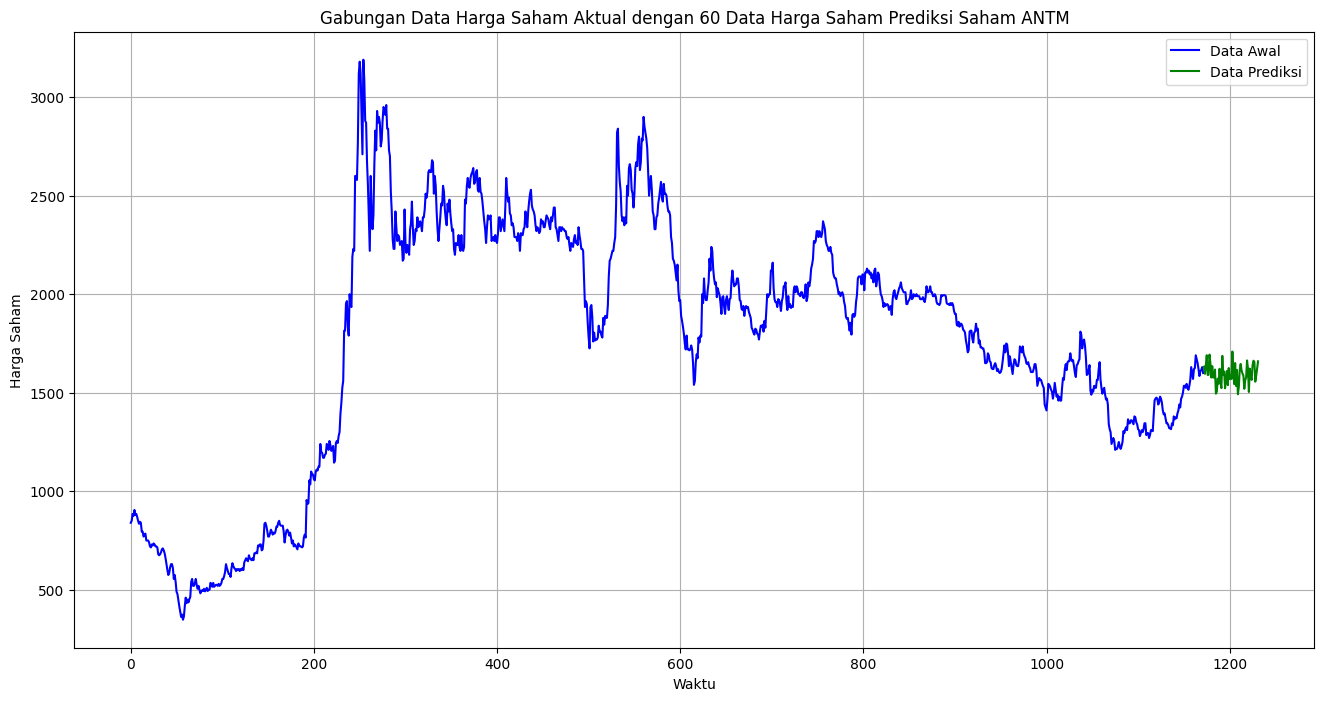

In [30]:
# ==============================================================================
# SEL 16: Visualisasi Gabungan Data Aktual & Prediksi Masa Depan
# ==============================================================================

future_df['Day'] = range(len(df), len(df) + 60)
# Gabungan data sebelumnya dengan prediksi masa depan
combined_df = pd.concat([
    pd.DataFrame({'Day': range(len(df)), 'Close': df['Close']}),
    future_df.rename(columns={'Future Predictions': 'Close'})
], ignore_index=True)

plt.figure(figsize=(16, 8))
plt.plot(combined_df['Day'][:len(df)], combined_df['Close'][:len(df)], label='Data Awal', color='blue')
plt.plot(combined_df['Day'][len(df):], combined_df['Close'][len(df):], label='Data Prediksi', color='green') #, marker='o')
plt.title(f'Gabungan Data Harga Saham Aktual dengan 60 Data Harga Saham Prediksi Saham {stock_name}')
plt.xlabel('Waktu')
plt.ylabel('Harga Saham')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# ==============================================================================
# Menyimpan Prediksi Masa Depan
# ==============================================================================

# Simpan prediksi masa depan ke DataFrame
future_df.to_excel('future_predictions.xlsx', index=False)
print("\nPrediksi 60 Data ke Depan disimpan ke 'future_predictions.xlsx'")


Prediksi 60 Data ke Depan disimpan ke 'future_predictions.xlsx'


In [32]:
# ==============================================================================
# Visualisasi Return Harian
# ==============================================================================

print("\n=== Visualisasi Return Harian ===")
# Hitung return harian (dalam persen)
df['Return Harian'] = df['Close'].pct_change()
# Hapus nilai NaN pertama (karena tidak ada return untuk hari pertama)
df.dropna(inplace=True)

# Plot return saham dengan label berbahasa Indonesia
fig = px.line(
    df,
    x=df.index,
    y='Return Harian',
    title='Grafik <i>Return</i> Harian Saham ADRO',
    labels={
        'Date': 'Tanggal',
        'Return Harian': 'Return Harian'
    }
)

# Tambahkan pengaturan layout
fig.update_layout(
    xaxis_title='Tanggal',
    yaxis_title='<i>Return</i> Harian',
    plot_bgcolor='white',
    font_size=15,
    title_x=0.5,
    font_family='Times New Roman',
    xaxis=dict(showline=True,linecolor='black', showgrid=True,              # Menampilkan garis bantu X
        gridcolor='lightgray'),
    yaxis=dict(showline=True,linecolor='black', showgrid=True,              # Menampilkan garis bantu X
        gridcolor='lightgray')
)

fig.show()


=== Visualisasi Return Harian ===
